/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8347 - loss: 0.3483 - val_accuracy: 0.7465 - val_loss: 0.4139
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9429 - loss: 0.1431 - val_accuracy: 0.9384 - val_loss: 0.1998
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9457 - loss: 0.1264 - val_accuracy: 0.8355 - val_loss: 0.3797
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9480 - loss: 0.1154 - val_accuracy: 0.9086 - val_loss: 0.2605
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9664 - loss: 0.0771 - val_accuracy: 0.9557 - val_loss: 0.1447
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9666 - loss: 0.0818 - val_accuracy: 0.9634 - val_loss: 0.1483
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9675 - loss: 0.0766 - val_accuracy: 0.9649 - val_loss: 0.1537
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9705 - loss: 0.0686 - val_accu

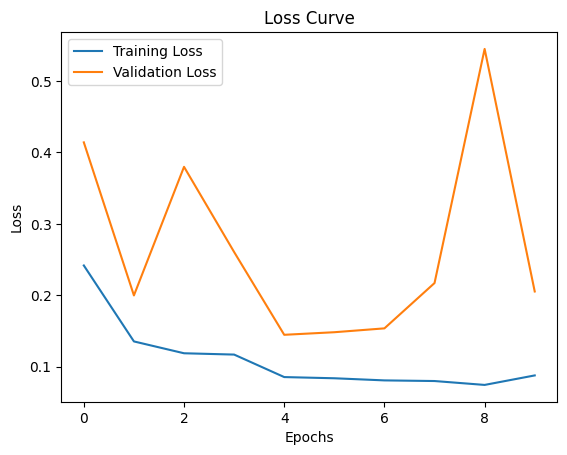

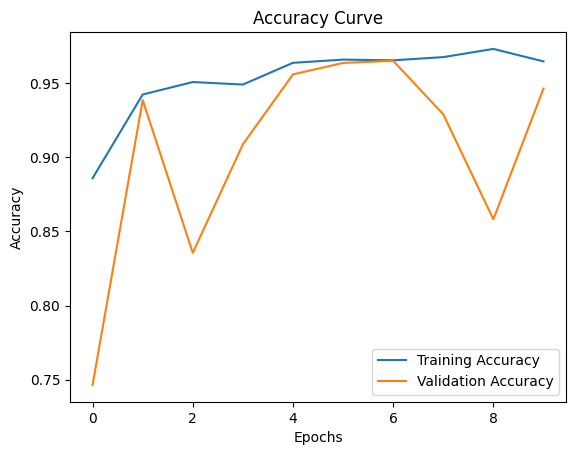

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load datasets
# Replace with your file paths
train_data = pd.read_csv('BATADAL_dataset04.csv')
test_data = pd.read_csv('BATADAL_test_dataset.csv')

# Replace -999 with 0 in the datasets
train_data.replace(-999, 0, inplace=True)
test_data.replace(-999, 0, inplace=True)

# Convert the first column (timestamp) to datetime
train_data['timestamp'] = pd.to_datetime(train_data.iloc[:, 0], format='%d/%m/%y %H')
test_data['timestamp'] = pd.to_datetime(test_data.iloc[:, 0], format='%d/%m/%y %H')

# Extract features from the timestamp
train_data['hour'] = train_data['timestamp'].dt.hour                  # Extract hour of the day
train_data['day_of_week'] = train_data['timestamp'].dt.dayofweek      # Extract day of the week (0=Monday, 6=Sunday)
train_data['is_weekend'] = (train_data['day_of_week'] >= 5).astype(int)  # Binary: 1 if Saturday or Sunday, else 0

test_data['hour'] = test_data['timestamp'].dt.hour
test_data['day_of_week'] = test_data['timestamp'].dt.dayofweek
test_data['is_weekend'] = (test_data['day_of_week'] >= 5).astype(int)

# Drop the original timestamp column
train_data.drop(columns=['timestamp', train_data.columns[0]], inplace=True)
test_data.drop(columns=['timestamp', test_data.columns[0]], inplace=True)

# Define features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude the last column (target variable)
y_train = train_data.iloc[:, -1].values   # Last column as label
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
time_steps = 10
def create_sequences(data, labels, time_steps):
    sequences, seq_labels = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        seq_labels.append(labels[i + time_steps])
    return np.array(sequences), np.array(seq_labels)

X_train, y_train = create_sequences(X_train, y_train, time_steps)
X_test, y_test = create_sequences(X_test, y_test, time_steps)

# Convert labels to categorical (for binary classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.iloc[:, -1]),
    y=train_data.iloc[:, -1]
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: attack and no attack
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(classification_report(y_test, y_pred))

# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()